In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
import random
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
import math
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc, classification_report, roc_auc_score, average_precision_score, confusion_matrix, accuracy_score
!pip3 install eli5
!pip install shap
import eli5
from eli5.sklearn import PermutationImportance
import shap
from google.colab import drive 

Instructions for updating:
non-resource variables are not supported in the long term
     |████████████████████████████████| 106 kB 5.4 MB/s 
     |████████████████████████████████| 371 kB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509241 sha256=808f3a10e91dece007eab55a942974aea6373353f53c7aeae1329e41dec28020
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
# 데이터 로딩
df = pd.read_csv('/content/drive/Shareddrives/생체EMR 5팀/Data/time_series_iter.csv')
# df = pd.read_csv('/content/drive/Shareddrives/생체EMR 5팀/Data/time_series_knn_5.csv')
# df = pd.read_csv('/content/drive/Shareddrives/생체EMR 5팀/Data/time_series_knn_20.csv')
df = df[['hadm_id', 'sbp', 'dbp', 'resp', 'hr', 'temp_c', 'crystalloid_bolus', 'rbc', 'urine', 'event']]
st = pd.read_csv('/content/drive/Shareddrives/생체EMR 5팀/Data/static_df.csv')
df = st.iloc[:,:3].merge(df)

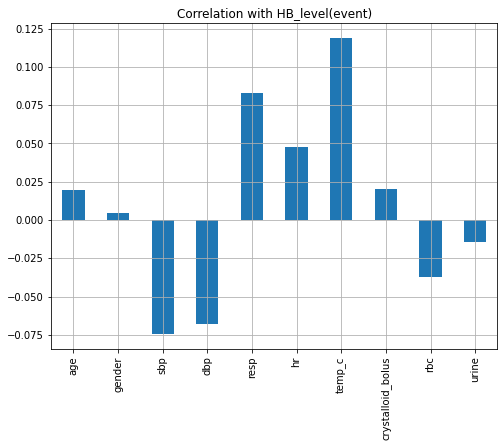

In [22]:
# event와 다른 feature 간의 correlation 

df.drop(['hadm_id', 'event'], axis=1).corrwith(df.event).plot(kind='bar', grid=True, figsize=(8, 6), title="Correlation with HB_level(event)")

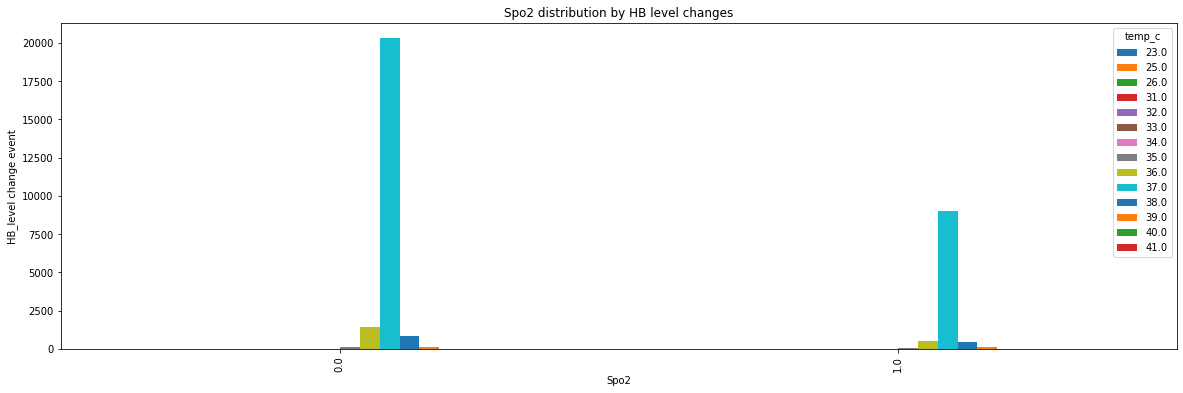

In [23]:
pd.crosstab(df.event,df.temp_c.round()).plot(kind="bar",figsize=(20,6))
plt.title('Spo2 distribution by HB level changes')
plt.xlabel('Spo2')
plt.ylabel('HB_level change event')
plt.show()

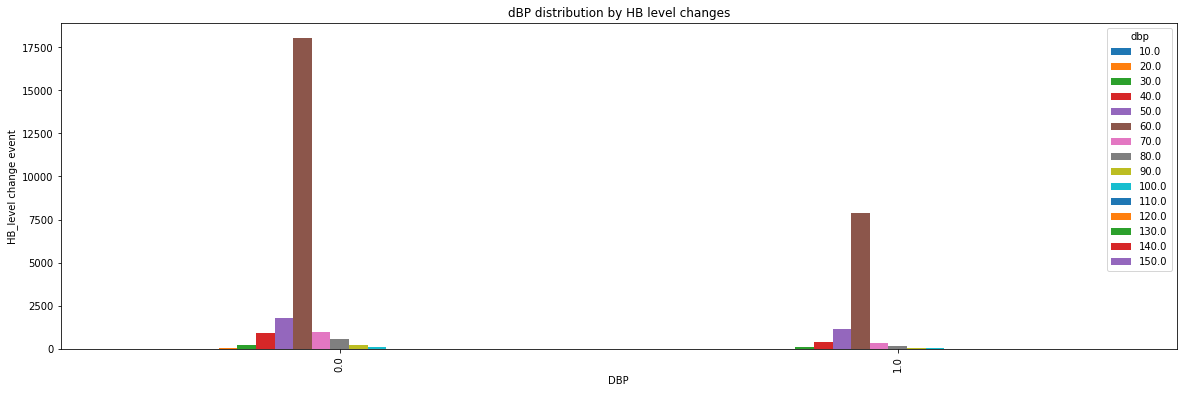

In [24]:
pd.crosstab(df.event,df.dbp.round(-1)).plot(kind="bar",figsize=(20,6))
plt.title('dBP distribution by HB level changes')
plt.xlabel('DBP')
plt.ylabel('HB_level change event')
plt.show()

In [25]:
# hadm_id 중복없이 리스트로 뽑고, df의 hadm_id에 해당하는 column의 데이터(프레임)를 x에 numpy array로 저장 
# hadm_id가 중복되면 (case 2개 이상), 한 hadm_id에 numpy array가 24 단위로 증가된 것만 남고, 나머지는 제거됨   

hadm_id =list(set(df['hadm_id'].tolist()))
column_name = df.columns[1:]
x = [df[df['hadm_id']==i][column_name].to_numpy() for i in hadm_id]


In [26]:
# 입력 데이터 만들기 
# x를 받아서 array가 48인 것은 event값에 따라 나누고, 24인 것과 최종 final_x, final_y로 지정

def data_split(np_array_list):
  final_x, final_y = [], []
  for np_array in np_array_list:
    if len(np_array) == 48:
      final_x.append(np_array[np.where(np_array[:, -1]==0)][:, :-1])
      final_y.append(0)
      final_x.append(np_array[np.where(np_array[:, -1]==1)][:, :-1])
      final_y.append(1)
    else:
      label = np_array[0, -1]
      final_x.append(np_array[:, :-1])
      final_y.append(label)

  return np.array(final_x), np.array(final_y)

In [27]:
final_x, final_y = data_split(x)
print("x shape:", final_x.shape, "y shape:", final_y.shape)

x shape: (1378, 24, 10) y shape: (1378,)


In [28]:
# train/test set 나누기 (7:3)  (colab에서 fit -> validation_data에 오류있어 사용 어려움)

x_train, x_test, y_train, y_test = train_test_split(final_x, final_y, random_state=100, test_size=0.3, shuffle=True) 
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(964, 24, 10)
(414, 24, 10)
(964,)
(414,)


In [29]:
# 데이터 불균형 정도
neg, pos = np.bincount(df['event'])
total = neg + pos
print('Total: {}\n  Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Total: 33072
  Positive: 10200 (30.84% of total)

Weight for class 0: 0.72
Weight for class 1: 1.62


In [30]:
# 모델 구성 (LSTM)

ls_model = Sequential()
ls_model.add(LSTM(64, return_sequences=True, input_shape=(final_x.shape[1],10))),
#ls_model.add(LSTM(64, return_sequences=True)),
ls_model.add(LSTM(64)),
ls_model.add(Dense(1, activation='sigmoid'))

ls_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 24, 64)            19200     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 52,289
Trainable params: 52,289
Non-trainable params: 0
_________________________________________________________________


In [31]:
# 학습
ls_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 50
history = ls_model.fit(x_train, y_train, epochs=num_epochs, batch_size = 12, class_weight=class_weight, verbose=1)

Train on 964 samples
Epoch 1/50
964/964 [==============================] - 2s 2ms/sample - loss: 0.6975 - acc: 0.5353
Epoch 2/50
964/964 [==============================] - 2s 2ms/sample - loss: 0.6839 - acc: 0.5747
Epoch 3/50
964/964 [==============================] - 2s 2ms/sample - loss: 0.6746 - acc: 0.5529
Epoch 4/50
964/964 [==============================] - 2s 2ms/sample - loss: 0.6690 - acc: 0.5913
Epoch 5/50
964/964 [==============================] - 2s 2ms/sample - loss: 0.6918 - acc: 0.5809
Epoch 6/50
964/964 [==============================] - 2s 2ms/sample - loss: 0.6681 - acc: 0.5902
Epoch 7/50
964/964 [==============================] - 2s 2ms/sample - loss: 0.6654 - acc: 0.5975
Epoch 8/50
964/964 [==============================] - 2s 2ms/sample - loss: 0.6711 - acc: 0.5737
Epoch 9/50
964/964 [==============================] - 2s 2ms/sample - loss: 0.6601 - acc: 0.5591
Epoch 10/50
964/964 [==============================] - 2s 2ms/sample - loss: 0.6617 - acc: 0.6058
Epoch 11

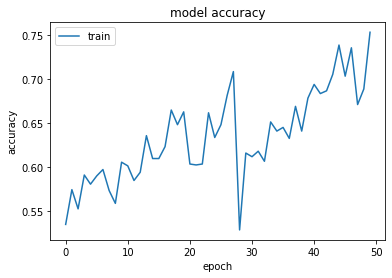

In [32]:
# Model Accuracy

plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

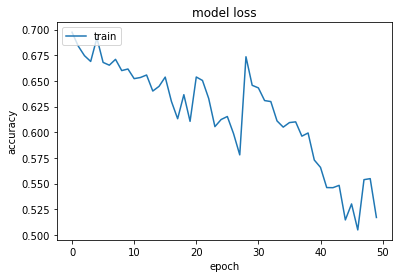

In [33]:
# Model Loss 

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [34]:
# 모델 평가

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='skyblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


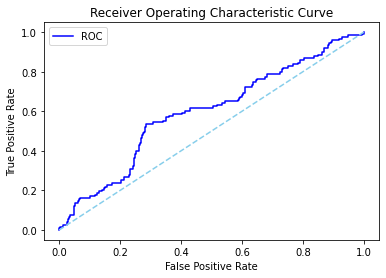

In [35]:
y_pred = (ls_model.predict(x_test) > 0.5).astype("int32")
y_prob = ls_model.predict_on_batch(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plot_roc_curve(fpr, tpr)

In [36]:
#loss, accuracy = ls_model.evaluate(x_test, y_test, batch_size=1) 
#print('Loss: %.4f' % loss, 'Accuracy: % .4f' % accuracy )
print("{} Accuracy Score: {:.2f}%".format(2, accuracy_score(y_test, y_pred)*100))
print('AUC: %.4f' % roc_auc_score(y_test, ls_model.predict(x_test)))
print(classification_report(y_test, y_pred))

2 Accuracy Score: 47.34%
AUC: 0.5946
              precision    recall  f1-score   support

         0.0       0.77      0.36      0.49       291
         1.0       0.33      0.75      0.46       123

    accuracy                           0.47       414
   macro avg       0.55      0.55      0.47       414
weighted avg       0.64      0.47      0.48       414



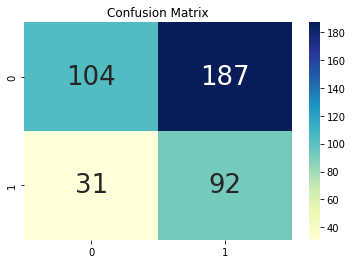

In [37]:
cm = confusion_matrix(y_test,y_pred)
cm_norm = confusion_matrix(y_test, y_pred, normalize='all')
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt="d", cbar=True, annot_kws={"size": 26})

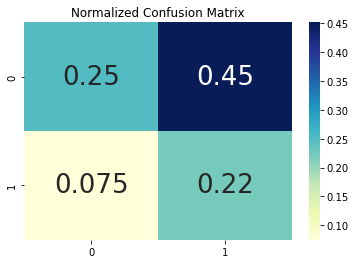

In [38]:
plt.title("Normalized Confusion Matrix")
sns.heatmap(cm_norm, annot=True, cmap="YlGnBu", cbar=True, annot_kws={"size": 26})

In [ ]:

background = x_train[np.random.choice(x_train.shape[0], 110, replace=False)]
explainer = shap.DeepExplainer((ls_model.layers[0].input, ls_model.layers[-1].output), background)
%time
shap_values = explainer.shap_values(x_train[:2000]) 

# print the JS visualization code to the notebook
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], feature_names=features)


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 11.4 µs


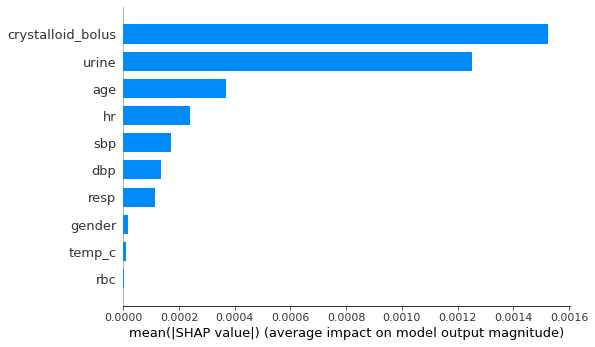

In [ ]:
features = df.columns[-11:-1]
shap.summary_plot(shap_values[0][:, 0, :], x_train[:][:, 0, :], features, plot_type="bar")


In [ ]:
shap.initjs()
shap.summary_plot(shap_values[0],feature_names=features, max_display=10, plot_type='bar')